In [1]:
import itertools as it
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import DataLoader, TensorDataset, random_split
import attention as att
import torch.optim as optim
from tqdm import trange

In [2]:
# For same initialization of weights/biases of model
torch.manual_seed(seed=999)
torch.set_float32_matmul_precision('high')

In [4]:
input_CG = np.load('/pscratch/sd/h/hbassi/2d_vlasov_data_coarse_scale_64.npy')
target_FG = np.load('/pscratch/sd/h/hbassi/2d_vlasov_data_fine_scale_128.npy') 
input_CG.shape, target_FG.shape

((78, 1, 192, 192), (78, 1, 384, 384))

In [5]:
### Define parameters in the NN 
# previous was 256 and 64
bond_dim = 256
num_heads = 64  ## bond_dim/num_heads must be a integer
num_layers = 2
input_dim = input_CG.shape[2]
output_dim = target_FG.shape[2]
print(input_dim, output_dim) 

192 384


In [6]:
vit_model_regression = att.VisionTransformer(
    img_height=input_dim,        # Image height
    img_width=input_dim,       # Image width (non-square image)
    patch_size_h=5,      # Patch size for height
    patch_size_w=5,     # Patch size for width
    input_dim=1,         # 1 for single channel images
    num_heads=num_heads,         
    num_layers=num_layers,        
    bond_dim=bond_dim,        
    output_dim=output_dim**2,
    dropout = 0.1
)

In [7]:
device = 'cuda'
input_CG_tensor = torch.tensor(input_CG, dtype=torch.float32).to(device)
target_FG_tensor = torch.tensor(target_FG, dtype=torch.float32).to(device)

In [8]:
# Create the full dataset
dataset = TensorDataset(input_CG_tensor[:70], target_FG_tensor[:70])

# 80% training, 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [9]:
# Define loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(vit_model_regression.parameters(), lr=0.001)

In [10]:
# Training loop
num_epochs = 2000

In [11]:
vit_model_regression = vit_model_regression.to(device)
vit_model_regression = torch.compile(vit_model_regression)

In [13]:
for epoch in trange(num_epochs):
    vit_model_regression.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_dataloader):
        output = vit_model_regression(data)
        target_flat = target.view(-1, output_dim * output_dim)
        output = output.view(-1, output_dim* output_dim)
        #print(target_flat.shape, output.shape)
        loss = criterion(output, target_flat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.8f}')

        # Validation phase
        vit_model_regression.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_dataloader:
                output = vit_model_regression(data)
                target_flat = target.view(-1, output_dim * output_dim)
                output = output.view(-1, output_dim* output_dim)
                loss = criterion(output, target_flat)
                val_loss += loss.item()

        print(f'Validation Loss: {val_loss / len(val_dataloader):.8f}')
        print('=============================================================================')


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [1/2000], Loss: 0.23098880


  0%|          | 1/2000 [00:31<17:43:16, 31.91s/it]

Validation Loss: 0.12777191


  1%|          | 11/2000 [00:37<28:52,  1.15it/s]  

Epoch [11/2000], Loss: 0.02430979
Validation Loss: 0.02246860


  1%|          | 21/2000 [00:43<19:46,  1.67it/s]

Epoch [21/2000], Loss: 0.02006133
Validation Loss: 0.01924453


  2%|▏         | 31/2000 [00:49<19:25,  1.69it/s]

Epoch [31/2000], Loss: 0.01909763
Validation Loss: 0.01752838


  2%|▏         | 41/2000 [00:55<19:18,  1.69it/s]

Epoch [41/2000], Loss: 0.01755608
Validation Loss: 0.01642745


  3%|▎         | 51/2000 [01:01<19:13,  1.69it/s]

Epoch [51/2000], Loss: 0.01644965
Validation Loss: 0.01535340


  3%|▎         | 61/2000 [01:06<19:07,  1.69it/s]

Epoch [61/2000], Loss: 0.01438921
Validation Loss: 0.01317054


  4%|▎         | 71/2000 [01:12<19:00,  1.69it/s]

Epoch [71/2000], Loss: 0.01395918
Validation Loss: 0.01293261


  4%|▍         | 81/2000 [01:18<18:54,  1.69it/s]

Epoch [81/2000], Loss: 0.01339613
Validation Loss: 0.01263106


  5%|▍         | 91/2000 [01:24<18:48,  1.69it/s]

Epoch [91/2000], Loss: 0.01270149
Validation Loss: 0.01177551


  5%|▌         | 101/2000 [01:30<18:43,  1.69it/s]

Epoch [101/2000], Loss: 0.01282983
Validation Loss: 0.01207331


  6%|▌         | 111/2000 [01:36<18:37,  1.69it/s]

Epoch [111/2000], Loss: 0.01220292
Validation Loss: 0.01087683


  6%|▌         | 121/2000 [01:41<18:31,  1.69it/s]

Epoch [121/2000], Loss: 0.01201584
Validation Loss: 0.01080818


  7%|▋         | 131/2000 [01:47<18:31,  1.68it/s]

Epoch [131/2000], Loss: 0.01144910
Validation Loss: 0.01032326


  7%|▋         | 141/2000 [01:53<18:19,  1.69it/s]

Epoch [141/2000], Loss: 0.01102258
Validation Loss: 0.01028319


  8%|▊         | 151/2000 [01:59<18:13,  1.69it/s]

Epoch [151/2000], Loss: 0.01058625
Validation Loss: 0.00948517


  8%|▊         | 161/2000 [02:05<18:12,  1.68it/s]

Epoch [161/2000], Loss: 0.01050843
Validation Loss: 0.00950619


  9%|▊         | 171/2000 [02:10<18:01,  1.69it/s]

Epoch [171/2000], Loss: 0.01010480
Validation Loss: 0.00896599


  9%|▉         | 181/2000 [02:16<17:58,  1.69it/s]

Epoch [181/2000], Loss: 0.01017215
Validation Loss: 0.00922659


 10%|▉         | 191/2000 [02:22<17:50,  1.69it/s]

Epoch [191/2000], Loss: 0.00979129
Validation Loss: 0.00854507


 10%|█         | 201/2000 [02:28<17:44,  1.69it/s]

Epoch [201/2000], Loss: 0.00975944
Validation Loss: 0.00879002


 11%|█         | 211/2000 [02:34<17:37,  1.69it/s]

Epoch [211/2000], Loss: 0.00986428
Validation Loss: 0.00898830


 11%|█         | 221/2000 [02:40<17:31,  1.69it/s]

Epoch [221/2000], Loss: 0.00949359
Validation Loss: 0.00819724


 12%|█▏        | 231/2000 [02:45<17:25,  1.69it/s]

Epoch [231/2000], Loss: 0.00898977
Validation Loss: 0.00825723


 12%|█▏        | 241/2000 [02:51<17:25,  1.68it/s]

Epoch [241/2000], Loss: 0.00883812
Validation Loss: 0.00862470


 13%|█▎        | 251/2000 [02:57<17:14,  1.69it/s]

Epoch [251/2000], Loss: 0.00844515
Validation Loss: 0.00832041


 13%|█▎        | 261/2000 [03:03<17:08,  1.69it/s]

Epoch [261/2000], Loss: 0.00840643
Validation Loss: 0.00795730


 14%|█▎        | 271/2000 [03:09<17:04,  1.69it/s]

Epoch [271/2000], Loss: 0.00843165
Validation Loss: 0.00778044


 14%|█▍        | 281/2000 [03:15<16:59,  1.69it/s]

Epoch [281/2000], Loss: 0.00842741
Validation Loss: 0.00788478


 15%|█▍        | 291/2000 [03:20<16:50,  1.69it/s]

Epoch [291/2000], Loss: 0.00842307
Validation Loss: 0.00798617


 15%|█▌        | 301/2000 [03:26<16:44,  1.69it/s]

Epoch [301/2000], Loss: 0.00852508
Validation Loss: 0.00756743


 16%|█▌        | 311/2000 [03:32<16:38,  1.69it/s]

Epoch [311/2000], Loss: 0.00840580
Validation Loss: 0.00812275


 16%|█▌        | 321/2000 [03:38<16:32,  1.69it/s]

Epoch [321/2000], Loss: 0.00834101
Validation Loss: 0.00751526


 17%|█▋        | 331/2000 [03:44<16:26,  1.69it/s]

Epoch [331/2000], Loss: 0.00851139
Validation Loss: 0.00773800


 17%|█▋        | 341/2000 [03:49<16:21,  1.69it/s]

Epoch [341/2000], Loss: 0.00816340
Validation Loss: 0.00786020


 18%|█▊        | 351/2000 [03:55<16:15,  1.69it/s]

Epoch [351/2000], Loss: 0.00801639
Validation Loss: 0.00784851


 18%|█▊        | 361/2000 [04:01<16:09,  1.69it/s]

Epoch [361/2000], Loss: 0.00797069
Validation Loss: 0.00775280


 19%|█▊        | 371/2000 [04:07<16:03,  1.69it/s]

Epoch [371/2000], Loss: 0.00764033
Validation Loss: 0.00697569


 19%|█▉        | 381/2000 [04:13<16:00,  1.69it/s]

Epoch [381/2000], Loss: 0.00767446
Validation Loss: 0.00703281


 20%|█▉        | 391/2000 [04:19<15:51,  1.69it/s]

Epoch [391/2000], Loss: 0.00767877
Validation Loss: 0.00722927


 20%|██        | 401/2000 [04:24<15:45,  1.69it/s]

Epoch [401/2000], Loss: 0.00740729
Validation Loss: 0.00690908


 21%|██        | 411/2000 [04:30<15:39,  1.69it/s]

Epoch [411/2000], Loss: 0.00751803
Validation Loss: 0.00707803


 21%|██        | 421/2000 [04:36<15:33,  1.69it/s]

Epoch [421/2000], Loss: 0.00721968
Validation Loss: 0.00664444


 22%|██▏       | 431/2000 [04:42<15:27,  1.69it/s]

Epoch [431/2000], Loss: 0.00736967
Validation Loss: 0.00702411


 22%|██▏       | 441/2000 [04:48<15:28,  1.68it/s]

Epoch [441/2000], Loss: 0.00716301
Validation Loss: 0.00715799


 23%|██▎       | 451/2000 [04:54<15:17,  1.69it/s]

Epoch [451/2000], Loss: 0.00720689
Validation Loss: 0.00685899


 23%|██▎       | 461/2000 [04:59<15:10,  1.69it/s]

Epoch [461/2000], Loss: 0.00681367
Validation Loss: 0.00641200


 24%|██▎       | 471/2000 [05:05<15:04,  1.69it/s]

Epoch [471/2000], Loss: 0.00708086
Validation Loss: 0.00682221


 24%|██▍       | 481/2000 [05:11<15:03,  1.68it/s]

Epoch [481/2000], Loss: 0.00673139
Validation Loss: 0.00640333


 25%|██▍       | 491/2000 [05:17<14:52,  1.69it/s]

Epoch [491/2000], Loss: 0.00694555
Validation Loss: 0.00649219


 25%|██▌       | 501/2000 [05:23<14:46,  1.69it/s]

Epoch [501/2000], Loss: 0.00674795
Validation Loss: 0.00652620


 26%|██▌       | 511/2000 [05:29<14:41,  1.69it/s]

Epoch [511/2000], Loss: 0.00698007
Validation Loss: 0.00680407


 26%|██▌       | 521/2000 [05:34<14:34,  1.69it/s]

Epoch [521/2000], Loss: 0.00658516
Validation Loss: 0.00634971


 27%|██▋       | 531/2000 [05:40<14:30,  1.69it/s]

Epoch [531/2000], Loss: 0.00668416
Validation Loss: 0.00638886


 27%|██▋       | 541/2000 [05:46<14:23,  1.69it/s]

Epoch [541/2000], Loss: 0.00681018
Validation Loss: 0.00636253


 28%|██▊       | 551/2000 [05:52<14:17,  1.69it/s]

Epoch [551/2000], Loss: 0.00666753
Validation Loss: 0.00634244


 28%|██▊       | 561/2000 [05:58<14:11,  1.69it/s]

Epoch [561/2000], Loss: 0.00647718
Validation Loss: 0.00600291


 29%|██▊       | 571/2000 [06:04<14:05,  1.69it/s]

Epoch [571/2000], Loss: 0.00623575
Validation Loss: 0.00671063


 29%|██▉       | 581/2000 [06:09<13:59,  1.69it/s]

Epoch [581/2000], Loss: 0.00659060
Validation Loss: 0.00602318


 30%|██▉       | 591/2000 [06:15<13:54,  1.69it/s]

Epoch [591/2000], Loss: 0.00629257
Validation Loss: 0.00611619


 30%|███       | 601/2000 [06:21<13:47,  1.69it/s]

Epoch [601/2000], Loss: 0.00632808
Validation Loss: 0.00627574


 31%|███       | 611/2000 [06:27<13:41,  1.69it/s]

Epoch [611/2000], Loss: 0.00612209
Validation Loss: 0.00621809


 31%|███       | 621/2000 [06:33<13:35,  1.69it/s]

Epoch [621/2000], Loss: 0.00621901
Validation Loss: 0.00609559


 32%|███▏      | 631/2000 [06:38<13:30,  1.69it/s]

Epoch [631/2000], Loss: 0.00617395
Validation Loss: 0.00612581


 32%|███▏      | 641/2000 [06:44<13:24,  1.69it/s]

Epoch [641/2000], Loss: 0.00612321
Validation Loss: 0.00623922


 33%|███▎      | 651/2000 [06:50<13:20,  1.68it/s]

Epoch [651/2000], Loss: 0.00617187
Validation Loss: 0.00641842


 33%|███▎      | 661/2000 [06:56<13:11,  1.69it/s]

Epoch [661/2000], Loss: 0.00591700
Validation Loss: 0.00614006


 34%|███▎      | 671/2000 [07:02<13:06,  1.69it/s]

Epoch [671/2000], Loss: 0.00586469
Validation Loss: 0.00588418


 34%|███▍      | 681/2000 [07:08<12:59,  1.69it/s]

Epoch [681/2000], Loss: 0.00572857
Validation Loss: 0.00615112


 35%|███▍      | 691/2000 [07:14<13:04,  1.67it/s]

Epoch [691/2000], Loss: 0.00563698
Validation Loss: 0.00600109


 35%|███▌      | 701/2000 [07:19<12:48,  1.69it/s]

Epoch [701/2000], Loss: 0.00574005
Validation Loss: 0.00602549


 36%|███▌      | 711/2000 [07:25<12:42,  1.69it/s]

Epoch [711/2000], Loss: 0.00566090
Validation Loss: 0.00643670


 36%|███▌      | 721/2000 [07:31<12:36,  1.69it/s]

Epoch [721/2000], Loss: 0.00558081
Validation Loss: 0.00639790


 37%|███▋      | 731/2000 [07:37<12:30,  1.69it/s]

Epoch [731/2000], Loss: 0.00562279
Validation Loss: 0.00624462


 37%|███▋      | 741/2000 [07:43<12:25,  1.69it/s]

Epoch [741/2000], Loss: 0.00534296
Validation Loss: 0.00609222


 38%|███▊      | 751/2000 [07:48<12:19,  1.69it/s]

Epoch [751/2000], Loss: 0.00535071
Validation Loss: 0.00635172


 38%|███▊      | 761/2000 [07:54<12:12,  1.69it/s]

Epoch [761/2000], Loss: 0.00536546
Validation Loss: 0.00643330


 39%|███▊      | 771/2000 [08:00<12:07,  1.69it/s]

Epoch [771/2000], Loss: 0.00544479
Validation Loss: 0.00702503


 39%|███▉      | 781/2000 [08:06<12:02,  1.69it/s]

Epoch [781/2000], Loss: 0.00532925
Validation Loss: 0.00641516


 40%|███▉      | 791/2000 [08:12<11:55,  1.69it/s]

Epoch [791/2000], Loss: 0.00538874
Validation Loss: 0.00664377


 40%|████      | 801/2000 [08:18<11:49,  1.69it/s]

Epoch [801/2000], Loss: 0.00539329
Validation Loss: 0.00656358


 41%|████      | 811/2000 [08:23<11:43,  1.69it/s]

Epoch [811/2000], Loss: 0.00533047
Validation Loss: 0.00657563


 41%|████      | 821/2000 [08:29<11:37,  1.69it/s]

Epoch [821/2000], Loss: 0.00516210
Validation Loss: 0.00648769


 42%|████▏     | 831/2000 [08:35<11:31,  1.69it/s]

Epoch [831/2000], Loss: 0.00498439
Validation Loss: 0.00663116


 42%|████▏     | 841/2000 [08:41<11:25,  1.69it/s]

Epoch [841/2000], Loss: 0.00491523
Validation Loss: 0.00650381


 43%|████▎     | 851/2000 [08:47<11:19,  1.69it/s]

Epoch [851/2000], Loss: 0.00542504
Validation Loss: 0.00701129


 43%|████▎     | 861/2000 [08:53<11:14,  1.69it/s]

Epoch [861/2000], Loss: 0.00497439
Validation Loss: 0.00616025


 44%|████▎     | 871/2000 [08:58<11:07,  1.69it/s]

Epoch [871/2000], Loss: 0.00485631
Validation Loss: 0.00651858


 44%|████▍     | 881/2000 [09:04<11:01,  1.69it/s]

Epoch [881/2000], Loss: 0.00471425
Validation Loss: 0.00643282


 45%|████▍     | 891/2000 [09:10<10:56,  1.69it/s]

Epoch [891/2000], Loss: 0.00481616
Validation Loss: 0.00654500


 45%|████▌     | 901/2000 [09:16<10:50,  1.69it/s]

Epoch [901/2000], Loss: 0.00444690
Validation Loss: 0.00646419


 46%|████▌     | 911/2000 [09:22<10:44,  1.69it/s]

Epoch [911/2000], Loss: 0.00450012
Validation Loss: 0.00667294


 46%|████▌     | 921/2000 [09:27<10:38,  1.69it/s]

Epoch [921/2000], Loss: 0.00471002
Validation Loss: 0.00651949


 47%|████▋     | 931/2000 [09:33<10:32,  1.69it/s]

Epoch [931/2000], Loss: 0.00465699
Validation Loss: 0.00674855


 47%|████▋     | 941/2000 [09:39<10:27,  1.69it/s]

Epoch [941/2000], Loss: 0.00446633
Validation Loss: 0.00717326


 48%|████▊     | 951/2000 [09:45<10:20,  1.69it/s]

Epoch [951/2000], Loss: 0.00459967
Validation Loss: 0.00674837


 48%|████▊     | 961/2000 [09:51<10:14,  1.69it/s]

Epoch [961/2000], Loss: 0.00443825
Validation Loss: 0.00637239


 49%|████▊     | 971/2000 [09:57<10:08,  1.69it/s]

Epoch [971/2000], Loss: 0.00439879
Validation Loss: 0.00682066


 49%|████▉     | 981/2000 [10:02<10:04,  1.69it/s]

Epoch [981/2000], Loss: 0.00422232
Validation Loss: 0.00661238


 50%|████▉     | 991/2000 [10:08<09:56,  1.69it/s]

Epoch [991/2000], Loss: 0.00432088
Validation Loss: 0.00657789


 50%|█████     | 1001/2000 [10:14<09:53,  1.68it/s]

Epoch [1001/2000], Loss: 0.00432851
Validation Loss: 0.00636217


 51%|█████     | 1011/2000 [10:20<09:56,  1.66it/s]

Epoch [1011/2000], Loss: 0.00400793
Validation Loss: 0.00619537


 51%|█████     | 1021/2000 [10:26<09:39,  1.69it/s]

Epoch [1021/2000], Loss: 0.00395854
Validation Loss: 0.00672060


 52%|█████▏    | 1031/2000 [10:32<09:33,  1.69it/s]

Epoch [1031/2000], Loss: 0.00462885
Validation Loss: 0.00685407


 52%|█████▏    | 1041/2000 [10:37<09:27,  1.69it/s]

Epoch [1041/2000], Loss: 0.00392475
Validation Loss: 0.00611207


 53%|█████▎    | 1051/2000 [10:43<09:21,  1.69it/s]

Epoch [1051/2000], Loss: 0.00363921
Validation Loss: 0.00638846


 53%|█████▎    | 1061/2000 [10:49<09:15,  1.69it/s]

Epoch [1061/2000], Loss: 0.00373573
Validation Loss: 0.00651940


 54%|█████▎    | 1071/2000 [10:55<09:09,  1.69it/s]

Epoch [1071/2000], Loss: 0.00371025
Validation Loss: 0.00670155


 54%|█████▍    | 1081/2000 [11:01<09:03,  1.69it/s]

Epoch [1081/2000], Loss: 0.00377812
Validation Loss: 0.00659928


 55%|█████▍    | 1091/2000 [11:07<08:57,  1.69it/s]

Epoch [1091/2000], Loss: 0.00382617
Validation Loss: 0.00693124


 55%|█████▌    | 1101/2000 [11:12<08:51,  1.69it/s]

Epoch [1101/2000], Loss: 0.00367631
Validation Loss: 0.00652269


 56%|█████▌    | 1111/2000 [11:18<08:45,  1.69it/s]

Epoch [1111/2000], Loss: 0.00359043
Validation Loss: 0.00623741


 56%|█████▌    | 1121/2000 [11:24<08:47,  1.67it/s]

Epoch [1121/2000], Loss: 0.00358100
Validation Loss: 0.00643650


 57%|█████▋    | 1131/2000 [11:30<08:33,  1.69it/s]

Epoch [1131/2000], Loss: 0.00343817
Validation Loss: 0.00647332


 57%|█████▋    | 1141/2000 [11:36<08:30,  1.68it/s]

Epoch [1141/2000], Loss: 0.00329258
Validation Loss: 0.00630128


 58%|█████▊    | 1151/2000 [11:42<08:22,  1.69it/s]

Epoch [1151/2000], Loss: 0.00310166
Validation Loss: 0.00662406


 58%|█████▊    | 1161/2000 [11:47<08:16,  1.69it/s]

Epoch [1161/2000], Loss: 0.00337115
Validation Loss: 0.00639467


 59%|█████▊    | 1171/2000 [11:53<08:10,  1.69it/s]

Epoch [1171/2000], Loss: 0.00319428
Validation Loss: 0.00605590


 59%|█████▉    | 1181/2000 [11:59<08:04,  1.69it/s]

Epoch [1181/2000], Loss: 0.00311384
Validation Loss: 0.00622472


 60%|█████▉    | 1191/2000 [12:05<07:58,  1.69it/s]

Epoch [1191/2000], Loss: 0.00336882
Validation Loss: 0.00641491


 60%|██████    | 1201/2000 [12:11<07:52,  1.69it/s]

Epoch [1201/2000], Loss: 0.00303555
Validation Loss: 0.00692571


 61%|██████    | 1211/2000 [12:16<07:47,  1.69it/s]

Epoch [1211/2000], Loss: 0.00321740
Validation Loss: 0.00630375


 61%|██████    | 1221/2000 [12:22<07:40,  1.69it/s]

Epoch [1221/2000], Loss: 0.00328020
Validation Loss: 0.00622620


 62%|██████▏   | 1231/2000 [12:28<07:34,  1.69it/s]

Epoch [1231/2000], Loss: 0.00305775
Validation Loss: 0.00601230


 62%|██████▏   | 1241/2000 [12:34<07:28,  1.69it/s]

Epoch [1241/2000], Loss: 0.00309257
Validation Loss: 0.00618325


 63%|██████▎   | 1251/2000 [12:40<07:23,  1.69it/s]

Epoch [1251/2000], Loss: 0.00310791
Validation Loss: 0.00648829


 63%|██████▎   | 1261/2000 [12:46<07:17,  1.69it/s]

Epoch [1261/2000], Loss: 0.00290567
Validation Loss: 0.00601252


 64%|██████▎   | 1271/2000 [12:51<07:12,  1.69it/s]

Epoch [1271/2000], Loss: 0.00282821
Validation Loss: 0.00597728


 64%|██████▍   | 1281/2000 [12:57<07:05,  1.69it/s]

Epoch [1281/2000], Loss: 0.00296922
Validation Loss: 0.00637081


 65%|██████▍   | 1291/2000 [13:03<06:59,  1.69it/s]

Epoch [1291/2000], Loss: 0.00275493
Validation Loss: 0.00606928


 65%|██████▌   | 1301/2000 [13:09<06:53,  1.69it/s]

Epoch [1301/2000], Loss: 0.00268092
Validation Loss: 0.00634987


 66%|██████▌   | 1311/2000 [13:15<06:47,  1.69it/s]

Epoch [1311/2000], Loss: 0.00277112
Validation Loss: 0.00585300


 66%|██████▌   | 1321/2000 [13:21<06:41,  1.69it/s]

Epoch [1321/2000], Loss: 0.00265139
Validation Loss: 0.00613397


 67%|██████▋   | 1331/2000 [13:26<06:35,  1.69it/s]

Epoch [1331/2000], Loss: 0.00271289
Validation Loss: 0.00582056


 67%|██████▋   | 1341/2000 [13:32<06:29,  1.69it/s]

Epoch [1341/2000], Loss: 0.00274558
Validation Loss: 0.00565235


 68%|██████▊   | 1351/2000 [13:38<06:23,  1.69it/s]

Epoch [1351/2000], Loss: 0.00267580
Validation Loss: 0.00584932


 68%|██████▊   | 1361/2000 [13:44<06:17,  1.69it/s]

Epoch [1361/2000], Loss: 0.00272239
Validation Loss: 0.00540110


 69%|██████▊   | 1371/2000 [13:50<06:15,  1.68it/s]

Epoch [1371/2000], Loss: 0.00274994
Validation Loss: 0.00563490


 69%|██████▉   | 1381/2000 [13:55<06:06,  1.69it/s]

Epoch [1381/2000], Loss: 0.00271912
Validation Loss: 0.00574039


 70%|██████▉   | 1391/2000 [14:01<06:00,  1.69it/s]

Epoch [1391/2000], Loss: 0.00263841
Validation Loss: 0.00610793


 70%|███████   | 1401/2000 [14:07<05:54,  1.69it/s]

Epoch [1401/2000], Loss: 0.00247727
Validation Loss: 0.00586751


 71%|███████   | 1411/2000 [14:13<05:48,  1.69it/s]

Epoch [1411/2000], Loss: 0.00268197
Validation Loss: 0.00558153


 71%|███████   | 1421/2000 [14:19<05:42,  1.69it/s]

Epoch [1421/2000], Loss: 0.00252527
Validation Loss: 0.00594315


 72%|███████▏  | 1431/2000 [14:25<05:36,  1.69it/s]

Epoch [1431/2000], Loss: 0.00253662
Validation Loss: 0.00584167


 72%|███████▏  | 1441/2000 [14:30<05:30,  1.69it/s]

Epoch [1441/2000], Loss: 0.00248072
Validation Loss: 0.00510205


 73%|███████▎  | 1451/2000 [14:36<05:24,  1.69it/s]

Epoch [1451/2000], Loss: 0.00250954
Validation Loss: 0.00550164


 73%|███████▎  | 1461/2000 [14:42<05:18,  1.69it/s]

Epoch [1461/2000], Loss: 0.00248814
Validation Loss: 0.00554686


 74%|███████▎  | 1471/2000 [14:48<05:13,  1.69it/s]

Epoch [1471/2000], Loss: 0.00275621
Validation Loss: 0.00575157


 74%|███████▍  | 1481/2000 [14:54<05:07,  1.69it/s]

Epoch [1481/2000], Loss: 0.00244033
Validation Loss: 0.00553652


 75%|███████▍  | 1491/2000 [15:00<05:00,  1.69it/s]

Epoch [1491/2000], Loss: 0.00254400
Validation Loss: 0.00554007


 75%|███████▌  | 1501/2000 [15:05<04:55,  1.69it/s]

Epoch [1501/2000], Loss: 0.00240069
Validation Loss: 0.00523277


 76%|███████▌  | 1511/2000 [15:11<04:52,  1.67it/s]

Epoch [1511/2000], Loss: 0.00242322
Validation Loss: 0.00531800


 76%|███████▌  | 1521/2000 [15:17<04:43,  1.69it/s]

Epoch [1521/2000], Loss: 0.00235199
Validation Loss: 0.00511431


 77%|███████▋  | 1531/2000 [15:23<04:37,  1.69it/s]

Epoch [1531/2000], Loss: 0.00238024
Validation Loss: 0.00528915


 77%|███████▋  | 1541/2000 [15:29<04:31,  1.69it/s]

Epoch [1541/2000], Loss: 0.00239908
Validation Loss: 0.00542210


 78%|███████▊  | 1551/2000 [15:35<04:25,  1.69it/s]

Epoch [1551/2000], Loss: 0.00255037
Validation Loss: 0.00522166


 78%|███████▊  | 1561/2000 [15:40<04:19,  1.69it/s]

Epoch [1561/2000], Loss: 0.00230797
Validation Loss: 0.00517658


 79%|███████▊  | 1571/2000 [15:46<04:14,  1.69it/s]

Epoch [1571/2000], Loss: 0.00226933
Validation Loss: 0.00538553


 79%|███████▉  | 1581/2000 [15:52<04:07,  1.69it/s]

Epoch [1581/2000], Loss: 0.00238030
Validation Loss: 0.00533146


 80%|███████▉  | 1591/2000 [15:58<04:01,  1.69it/s]

Epoch [1591/2000], Loss: 0.00225956
Validation Loss: 0.00516068


 80%|████████  | 1601/2000 [16:04<03:56,  1.69it/s]

Epoch [1601/2000], Loss: 0.00220457
Validation Loss: 0.00513906


 81%|████████  | 1611/2000 [16:10<03:50,  1.69it/s]

Epoch [1611/2000], Loss: 0.00226359
Validation Loss: 0.00494578


 81%|████████  | 1621/2000 [16:15<03:44,  1.69it/s]

Epoch [1621/2000], Loss: 0.00232569
Validation Loss: 0.00494724


 82%|████████▏ | 1631/2000 [16:21<03:38,  1.69it/s]

Epoch [1631/2000], Loss: 0.00215071
Validation Loss: 0.00499893


 82%|████████▏ | 1641/2000 [16:27<03:32,  1.69it/s]

Epoch [1641/2000], Loss: 0.00223426
Validation Loss: 0.00519524


 83%|████████▎ | 1651/2000 [16:33<03:26,  1.69it/s]

Epoch [1651/2000], Loss: 0.00213544
Validation Loss: 0.00517543


 83%|████████▎ | 1661/2000 [16:39<03:23,  1.66it/s]

Epoch [1661/2000], Loss: 0.00211312
Validation Loss: 0.00519748


 84%|████████▎ | 1671/2000 [16:45<03:14,  1.69it/s]

Epoch [1671/2000], Loss: 0.00205691
Validation Loss: 0.00541743


 84%|████████▍ | 1681/2000 [16:50<03:08,  1.69it/s]

Epoch [1681/2000], Loss: 0.00210286
Validation Loss: 0.00531160


 85%|████████▍ | 1691/2000 [16:56<03:02,  1.69it/s]

Epoch [1691/2000], Loss: 0.00217666
Validation Loss: 0.00500263


 85%|████████▌ | 1701/2000 [17:02<03:00,  1.65it/s]

Epoch [1701/2000], Loss: 0.00202831
Validation Loss: 0.00500718


 86%|████████▌ | 1711/2000 [17:08<02:51,  1.69it/s]

Epoch [1711/2000], Loss: 0.00198972
Validation Loss: 0.00488335


 86%|████████▌ | 1721/2000 [17:14<02:45,  1.69it/s]

Epoch [1721/2000], Loss: 0.00195869
Validation Loss: 0.00517418


 87%|████████▋ | 1731/2000 [17:20<02:39,  1.69it/s]

Epoch [1731/2000], Loss: 0.00205947
Validation Loss: 0.00528358


 87%|████████▋ | 1741/2000 [17:25<02:33,  1.69it/s]

Epoch [1741/2000], Loss: 0.00185912
Validation Loss: 0.00524806


 88%|████████▊ | 1751/2000 [17:31<02:27,  1.69it/s]

Epoch [1751/2000], Loss: 0.00207276
Validation Loss: 0.00518908


 88%|████████▊ | 1761/2000 [17:37<02:21,  1.69it/s]

Epoch [1761/2000], Loss: 0.00196522
Validation Loss: 0.00506164


 89%|████████▊ | 1771/2000 [17:43<02:15,  1.69it/s]

Epoch [1771/2000], Loss: 0.00212488
Validation Loss: 0.00535972


 89%|████████▉ | 1781/2000 [17:49<02:11,  1.67it/s]

Epoch [1781/2000], Loss: 0.00203980
Validation Loss: 0.00542192


 90%|████████▉ | 1791/2000 [17:55<02:03,  1.69it/s]

Epoch [1791/2000], Loss: 0.00253088
Validation Loss: 0.00535303


 90%|█████████ | 1801/2000 [18:01<02:01,  1.63it/s]

Epoch [1801/2000], Loss: 0.00185160
Validation Loss: 0.00535017


 91%|█████████ | 1811/2000 [18:06<01:51,  1.69it/s]

Epoch [1811/2000], Loss: 0.00187096
Validation Loss: 0.00511835


 91%|█████████ | 1821/2000 [18:12<01:46,  1.69it/s]

Epoch [1821/2000], Loss: 0.00187880
Validation Loss: 0.00528721


 92%|█████████▏| 1831/2000 [18:18<01:40,  1.69it/s]

Epoch [1831/2000], Loss: 0.00190121
Validation Loss: 0.00532690


 92%|█████████▏| 1841/2000 [18:24<01:34,  1.69it/s]

Epoch [1841/2000], Loss: 0.00168188
Validation Loss: 0.00552027


 93%|█████████▎| 1851/2000 [18:30<01:28,  1.69it/s]

Epoch [1851/2000], Loss: 0.00167615
Validation Loss: 0.00528601


 93%|█████████▎| 1861/2000 [18:35<01:22,  1.69it/s]

Epoch [1861/2000], Loss: 0.00167474
Validation Loss: 0.00548036


 94%|█████████▎| 1871/2000 [18:41<01:16,  1.69it/s]

Epoch [1871/2000], Loss: 0.00173359
Validation Loss: 0.00578454


 94%|█████████▍| 1881/2000 [18:47<01:11,  1.65it/s]

Epoch [1881/2000], Loss: 0.00159141
Validation Loss: 0.00521820


 95%|█████████▍| 1891/2000 [18:53<01:04,  1.69it/s]

Epoch [1891/2000], Loss: 0.00153260
Validation Loss: 0.00525653


 95%|█████████▌| 1901/2000 [18:59<00:58,  1.69it/s]

Epoch [1901/2000], Loss: 0.00169910
Validation Loss: 0.00525035


 96%|█████████▌| 1911/2000 [19:05<00:52,  1.69it/s]

Epoch [1911/2000], Loss: 0.00172436
Validation Loss: 0.00533420


 96%|█████████▌| 1921/2000 [19:11<00:46,  1.69it/s]

Epoch [1921/2000], Loss: 0.00171378
Validation Loss: 0.00507766


 97%|█████████▋| 1931/2000 [19:16<00:40,  1.69it/s]

Epoch [1931/2000], Loss: 0.00158074
Validation Loss: 0.00552956


 97%|█████████▋| 1941/2000 [19:22<00:34,  1.69it/s]

Epoch [1941/2000], Loss: 0.00153606
Validation Loss: 0.00530699


 98%|█████████▊| 1951/2000 [19:28<00:28,  1.69it/s]

Epoch [1951/2000], Loss: 0.00153846
Validation Loss: 0.00517720


 98%|█████████▊| 1961/2000 [19:34<00:23,  1.69it/s]

Epoch [1961/2000], Loss: 0.00161970
Validation Loss: 0.00516424


 99%|█████████▊| 1971/2000 [19:40<00:17,  1.69it/s]

Epoch [1971/2000], Loss: 0.00161141
Validation Loss: 0.00556625


 99%|█████████▉| 1981/2000 [19:45<00:11,  1.69it/s]

Epoch [1981/2000], Loss: 0.00151329
Validation Loss: 0.00536994


100%|█████████▉| 1991/2000 [19:51<00:05,  1.69it/s]

Epoch [1991/2000], Loss: 0.00144322
Validation Loss: 0.00534464


100%|██████████| 2000/2000 [19:57<00:00,  1.67it/s]


In [34]:
input_CG_test = input_CG[70:]  
target_FG_test = target_FG[70:]  

In [35]:
input_CG_test_tensor = torch.tensor(input_CG_test, dtype=torch.float32)
target_FG_test_tensor = torch.tensor(target_FG_test, dtype=torch.float32)

In [36]:
vit_model_regression.eval().cpu()

OptimizedModule(
  (_orig_mod): VisionTransformer(
    (patch_embed): PatchEmbedding(
      (linear_proj): Linear(in_features=25, out_features=256, bias=True)
    )
    (transformer): TransformerEncoderViT(
      (layers): ModuleList(
        (0-1): 2 x EncoderLayer(
          (self_attn): MultiHeadAttention(
            (q_linear): Linear(in_features=256, out_features=256, bias=False)
            (k_linear): Linear(in_features=256, out_features=256, bias=False)
            (v_linear): Linear(in_features=256, out_features=256, bias=False)
            (out): Linear(in_features=256, out_features=256, bias=True)
          )
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (fc_out): Linear(in_features=256, out_features=147456, bias=False)
    )
  )
)

In [37]:
predictions = []
targets = []
inputs = []  

with torch.no_grad():
 
    batch_size = 64
    for i in range(0, input_CG_test_tensor.shape[0], batch_size):
        data = input_CG_test_tensor[i:i + batch_size]
        target = target_FG_test_tensor[i:i + batch_size]

       
        #print(f"Batch Data shape: {data.shape}, Target shape: {target.shape}")

        output = vit_model_regression(data)  
     
        #print(f"Output shape before reshaping: {output.shape}")

        output = output.view(output.shape[0], 1, output_dim, output_dim)  

       
        predictions.append(output.numpy())
        targets.append(target.numpy())
        inputs.append(data.numpy())  
 

In [38]:
# Convert predictions, targets, and inputs to numpy arrays
predictions = np.concatenate(predictions, axis=0)  
targets = np.concatenate(targets, axis=0)  
inputs = np.concatenate(inputs, axis=0)  

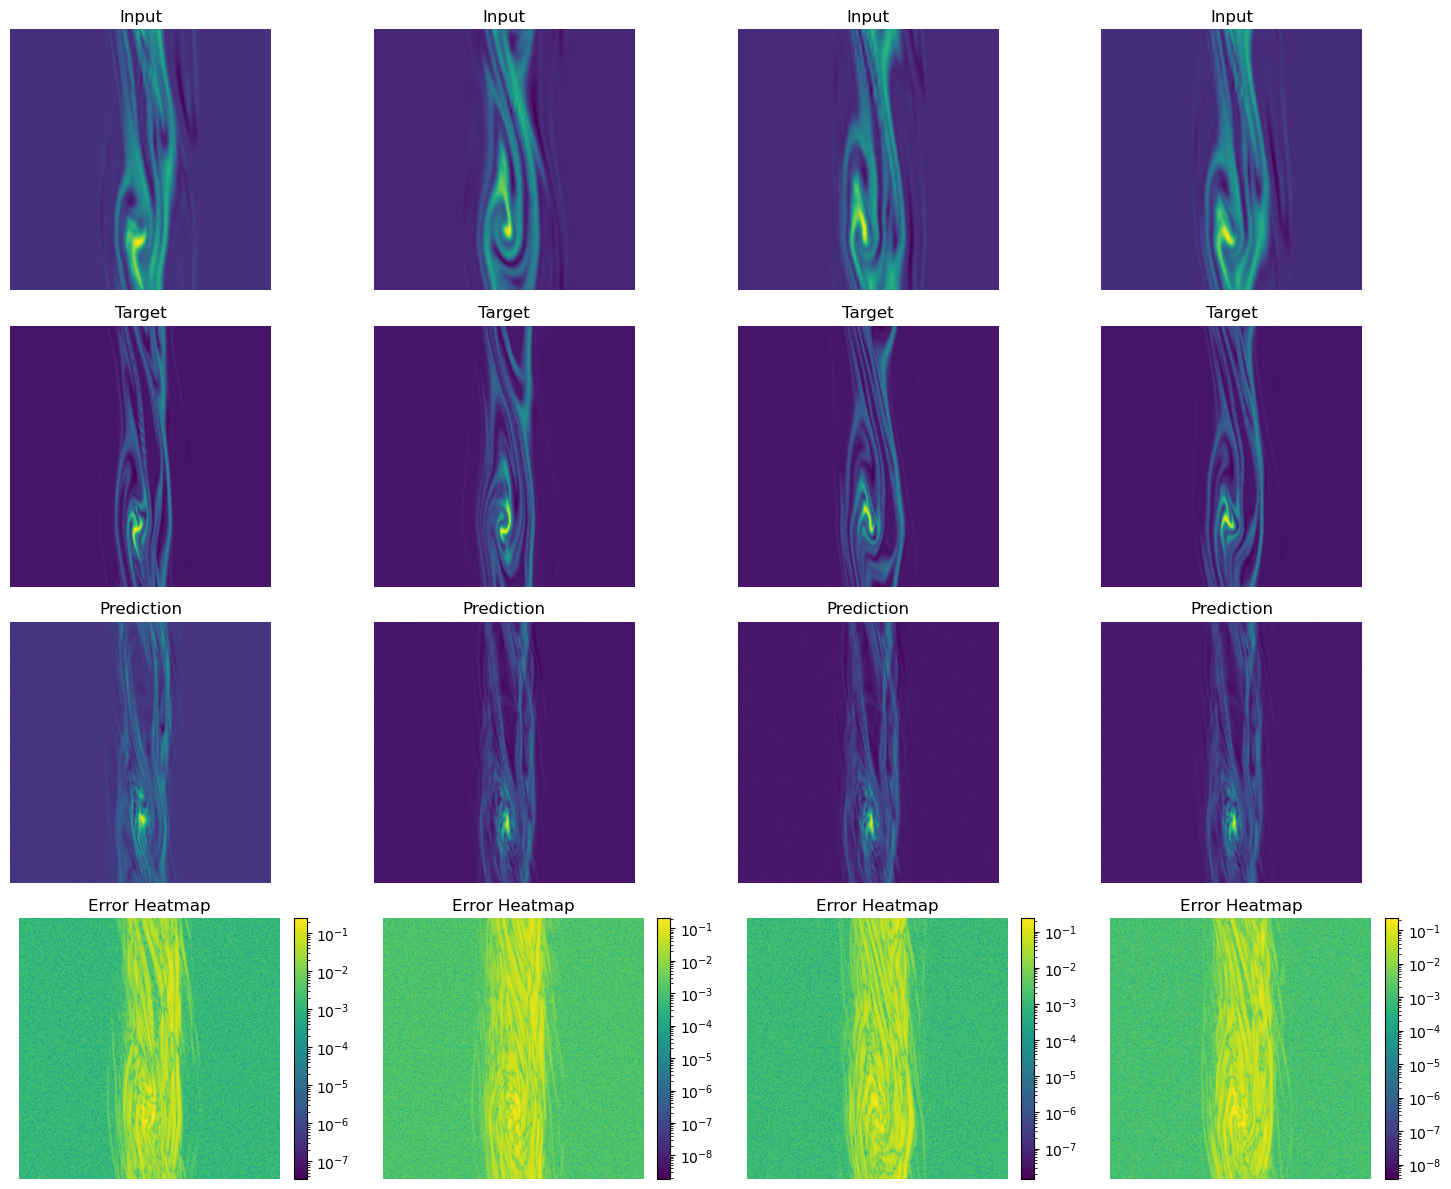

In [39]:
# Visualize a few predictions vs targets and inputs
num_samples = 4  # Number of samples to visualize
indices = np.random.choice(len(predictions), num_samples, replace=False)

plt.figure(figsize=(15, 12))  # Adjust height for the extra row
for i, idx in enumerate(indices):
    # Plot the input
    plt.subplot(4, num_samples, i + 1)
    plt.imshow(inputs[idx, 0], cmap='viridis')  # Use the first channel
    plt.title('Input')
    plt.axis('off')

    # Plot the target
    plt.subplot(4, num_samples, i + 1 + num_samples)
    plt.imshow(targets[idx, 0], cmap='viridis')  # Use the first channel
    plt.title('Target')
    plt.axis('off')

    # Plot the prediction
    plt.subplot(4, num_samples, i + 1 + 2 * num_samples)
    plt.imshow(predictions[idx, 0], cmap='viridis')  # Use the first channel
    plt.title('Prediction')
    plt.axis('off')

    # Calculate the error and plot the error heatmap with color bar
    error = np.abs(predictions[idx, 0] - targets[idx, 0])
    ax = plt.subplot(4, num_samples, i + 1 + 3 * num_samples)
    im = ax.imshow(error, cmap='viridis',norm=LogNorm(vmin=error.min(), vmax=error.max())) 
    plt.title('Error Heatmap')
    plt.axis('off')

    # Add color bar only to the error plot
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjust color bar size and position

plt.tight_layout()
#plt.savefig('vit_GS_model_test_result_blurred.png')
plt.show()

In [23]:
input_CG_test = input_CG[:70]  
target_FG_test = target_FG[:70]

In [24]:
input_CG_test_tensor = torch.tensor(input_CG_test, dtype=torch.float32)
target_FG_test_tensor = torch.tensor(target_FG_test, dtype=torch.float32)

In [25]:
vit_model_regression.eval()

OptimizedModule(
  (_orig_mod): VisionTransformer(
    (patch_embed): PatchEmbedding(
      (linear_proj): Linear(in_features=25, out_features=256, bias=True)
    )
    (transformer): TransformerEncoderViT(
      (layers): ModuleList(
        (0-1): 2 x EncoderLayer(
          (self_attn): MultiHeadAttention(
            (q_linear): Linear(in_features=256, out_features=256, bias=False)
            (k_linear): Linear(in_features=256, out_features=256, bias=False)
            (v_linear): Linear(in_features=256, out_features=256, bias=False)
            (out): Linear(in_features=256, out_features=256, bias=True)
          )
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (fc_out): Linear(in_features=256, out_features=147456, bias=False)
    )
  )
)

In [26]:
predictions = []
targets = []
inputs = []  

In [27]:
with torch.no_grad():
    batch_size = 64
    for i in range(0, input_CG_test_tensor.shape[0], batch_size):
        data = input_CG_test_tensor[i:i + batch_size]
        target = target_FG_test_tensor[i:i + batch_size]


        #print(f"Batch Data shape: {data.shape}, Target shape: {target.shape}")

        output = vit_model_regression(data) 
    
        #print(f"Output shape before reshaping: {output.shape}")

        output = output.view(output.shape[0], 1, output_dim, output_dim)  

        
        predictions.append(output.numpy())
        targets.append(target.numpy())
        inputs.append(data.numpy()) 

In [28]:
# Convert predictions, targets, and inputs to numpy arrays
predictions = np.concatenate(predictions, axis=0)  
targets = np.concatenate(targets, axis=0)  
inputs = np.concatenate(inputs, axis=0)  

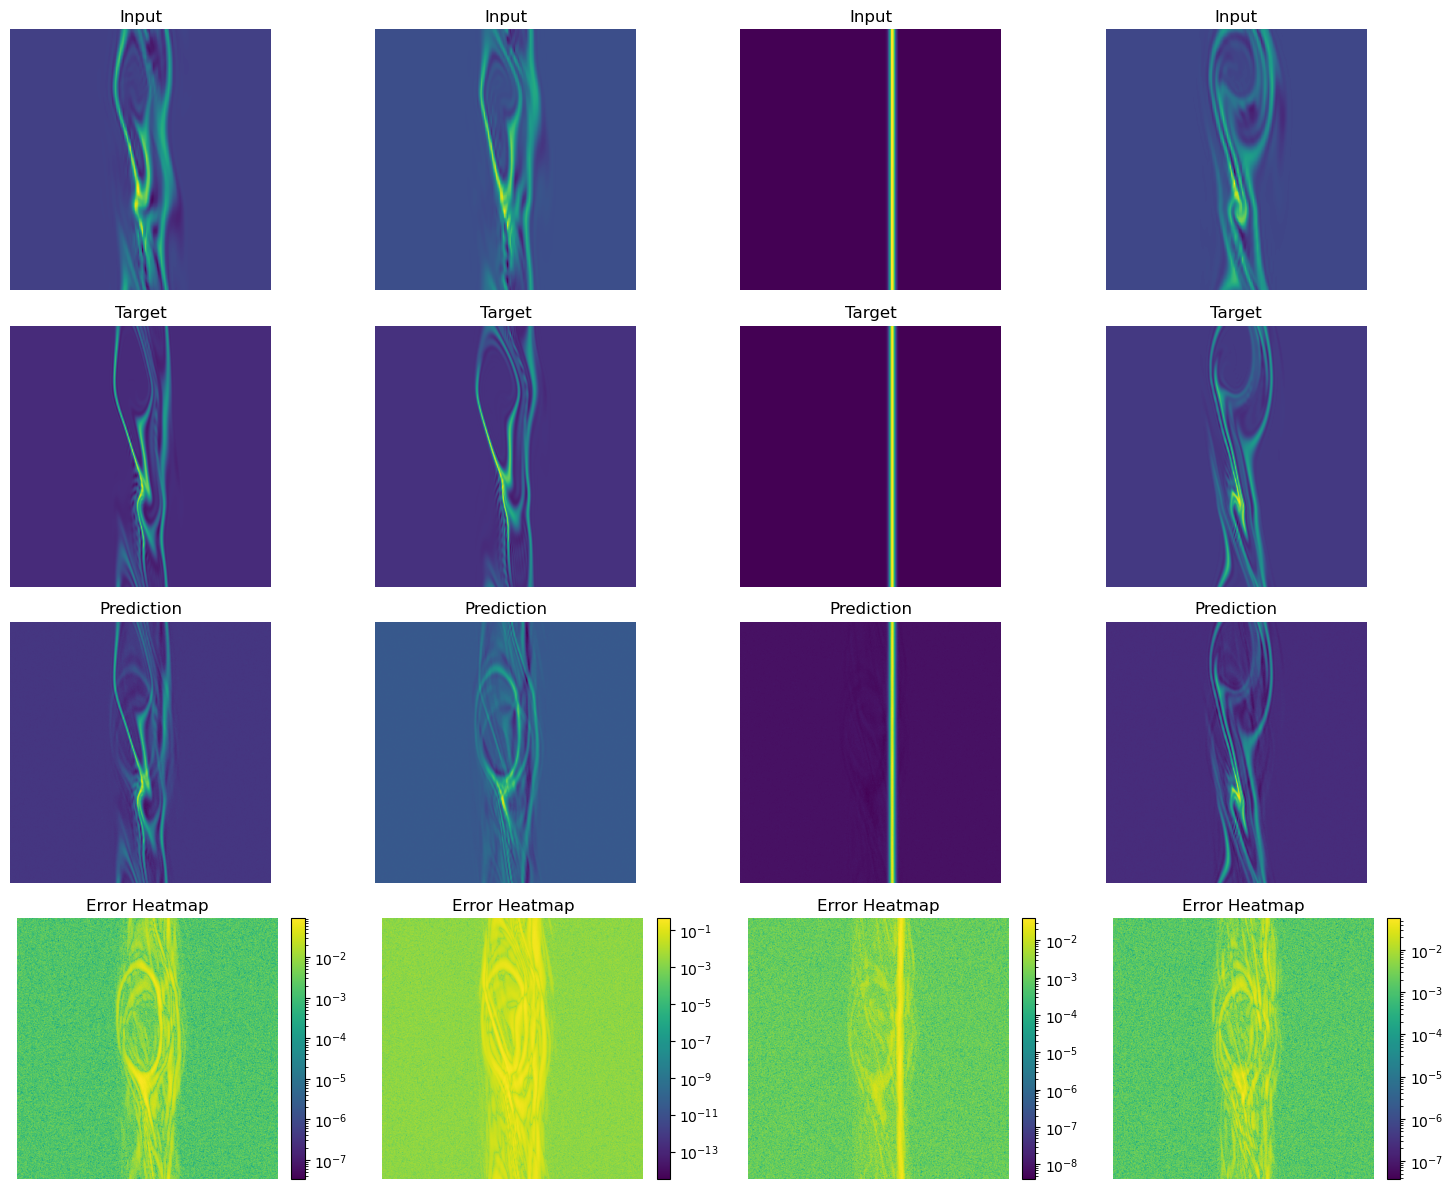

In [33]:
# Visualize a few predictions vs targets and inputs
from matplotlib.colors import LogNorm
num_samples = 4  # Number of samples to visualize
indices = np.random.choice(len(predictions), num_samples, replace=False)

plt.figure(figsize=(15, 12))  # Adjust height for the extra row
for i, idx in enumerate(indices):
    # Plot the input
    plt.subplot(4, num_samples, i + 1)
    plt.imshow(inputs[idx, 0], cmap='viridis')  # Use the first channel
    plt.title('Input Time')
    plt.axis('off')

    # Plot the target
    plt.subplot(4, num_samples, i + 1 + num_samples)
    plt.imshow(targets[idx, 0], cmap='viridis')  # Use the first channel
    plt.title('Target')
    plt.axis('off')

    # Plot the prediction
    plt.subplot(4, num_samples, i + 1 + 2 * num_samples)
    plt.imshow(predictions[idx, 0], cmap='viridis')  # Use the first channel
    plt.title('Prediction')
    plt.axis('off')

    # Calculate the error and plot the error heatmap with color bar
    error = (np.abs(predictions[idx, 0] - targets[idx, 0]))
    ax = plt.subplot(4, num_samples, i + 1 + 3 * num_samples)
    im = ax.imshow(error, cmap='viridis',norm=LogNorm(vmin=error.min(), vmax=error.max()))  # Viridis colormap for error heatmap
    plt.title('Error Heatmap')
    plt.axis('off')

    # Add color bar only to the error plot
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjust color bar size and position

plt.tight_layout()
#plt.savefig('vit_GS_model_training_result_blurred.png')